In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

In [277]:
import os
import sys
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd
pd.set_option('mode.chained_assignment',None)
import glob
import torch
import torchvision.transforms as transforms
from matplotlib.lines import Line2D
from matplotlib.ticker import MaxNLocator
from IPython.display import display
import numpy as np
from core.evaluate import accuracy
from matplotlib.ticker import MaxNLocator
import pose_estimation._init_paths
import dataset
from core.config import config
from core.config import update_config
import argparse
import models.pose_stacked_hg
%matplotlib inline

In [4]:
class DotDict(dict):
    """
    a dictionary that supports dot notation 
    as well as dictionary access notation 
    usage: d = DotDict() or d = DotDict({'val1':'first'})
    set attributes: d.val2 = 'second' or d['val2'] = 'second'
    get attributes: d.val2 or d['val2']
    """
    __getattr__ = dict.__getitem__
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__

    def __init__(self, dct):
        for key, value in dct.items():
            if hasattr(value, 'keys'):
                value = DotDict(value)
            self[key] = value

In [5]:
def parse_args():
    parser = argparse.ArgumentParser(description='Train keypoints network')
#     # general
#     parser.add_argument('--cfg',
#                         help='experiment configure file name',
#                         required=True,
#                         type=str)
    default_cfg = "experiments/mpii/hourglass/hourglass_8__td_0_9__distill_td_1_untied.yaml"
    parser.add_argument('--cfg',
                        help='experiment configure file name',
                        default=default_cfg,
                        type=str)

    args, rest = parser.parse_known_args()
    # update config
    update_config(args.cfg)

    # training
    parser.add_argument('--frequent',
                        help='frequency of logging',
                        default=config.PRINT_FREQ,
                        type=int)
    parser.add_argument('--max_batch_logs',
                        help='Max # of batches to save data from',
                        default=5,
                        type=int)
    parser.add_argument('--gpus',
                        help='gpus',
                        type=str)
    parser.add_argument('--workers',
                        help='num of dataloader workers',
                        type=int)
    parser.add_argument('--model-file',
                        help='model state file',
                        type=str)
    parser.add_argument('--result_root',
                        default="/hdd/mliuzzolino/TDPoseEstimation/results/",
                        help='Root for results',
                        type=str)
    parser.add_argument('--threshold',
                        type=float,
                        default=0.5,
                        help='Accuracy threshold [default=0.5]')
    parser.add_argument('--use-detect-bbox',
                        help='use detect bbox',
                        action='store_true')
    parser.add_argument('--flip-test',
                        help='use flip test',
                        action='store_true')
    parser.add_argument('--load_best_ckpt',
                        help='Load best checkpoint [default: load final]',
                        action='store_true')
    parser.add_argument('--post-process',
                        help='use post process',
                        action='store_true')
    parser.add_argument('--shift-heatmap',
                        help='shift heatmap',
                        action='store_true')
    parser.add_argument('--force_overwrite',
                        help='Force overwrite',
                        action='store_true')
    parser.add_argument('--vis_output_only',
                        help='Visualize output only; dont save results',
                        action='store_true')
    parser.add_argument('--save_all_data',
                        help='Save all data',
                        action='store_true')
    parser.add_argument('--coco-bbox-file',
                        help='coco detection bbox file',
                        type=str)

    args = parser.parse_args("")

    return args

In [6]:
def reset_config(config, args):
    if args.gpus:
        config.GPUS = args.gpus
    if args.workers:
        config.WORKERS = args.workers
    if args.use_detect_bbox:
        config.TEST.USE_GT_BBOX = not args.use_detect_bbox
    if args.flip_test:
        config.TEST.FLIP_TEST = args.flip_test
    if args.post_process:
        config.TEST.POST_PROCESS = args.post_process
    if args.shift_heatmap:
        config.TEST.SHIFT_HEATMAP = args.shift_heatmap
    if args.model_file:
        config.TEST.MODEL_FILE = args.model_file
    if args.coco_bbox_file:
        config.TEST.COCO_BBOX_FILE = args.coco_bbox_file

In [7]:
figs_root = "figs_speed_acc"
if not os.path.exists(figs_root):
  os.makedirs(figs_root)

In [312]:
args = parse_args()
reset_config(config, args)

/home/michael/TDPoseEstimation/lib/core/config.py:183: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  exp_config = edict(yaml.load(f))


## Load Dataset

In [25]:
normalize = transforms.Normalize(
  mean=[0.485, 0.456, 0.406],
  std=[0.229, 0.224, 0.225],
)
valid_dataset = eval('dataset.mpii')(
    config,
    config.DATASET.ROOT,
    config.DATASET.TEST_SET,
    False,
    transforms.Compose([
        transforms.ToTensor(),
        normalize,
    ])
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset,
    batch_size=config.TEST.BATCH_SIZE,
    shuffle=False,
    num_workers=0,
    pin_memory=False
)

## Load Model

In [291]:
root = f"experiments/mpii/hourglass"

In [314]:
exp_paths = glob.glob(f"{root}/*")
for exp_path in exp_paths:
  if "hourglass_8__td_1.yaml" in exp_path:
    break

In [315]:
exp_path

'experiments/mpii/hourglass/hourglass_8__td_1.yaml'

In [316]:
args.cfg = exp_path
update_config(args.cfg)

In [317]:
model = models.pose_stacked_hg.get_pose_net(config, is_train=False)

Sharing weights!


In [323]:
n_params = 0
for key, params in model.named_parameters():
  if "feature_maps" in key and "feature_maps.0" not in key:
    continue
  if "logit_maps" in key and "logit_maps.0" not in key:
    continue
  if "remaps" in key and "remaps.0" not in key:
    continue
  n_params += params.numel()

# Load Experiments

In [10]:
def parse_basename(basename):
  # Untied student weights, distillation
  if ("untied_weights" in basename) and ("distill" in basename):
    distillation = True
    tied_weights = False
    teacher_td = basename.split("__distill__TD_")[1].split("__untied")[0]
    teacher_td = float(teacher_td)
    student_td = float(basename.split("__TD_")[1].split("__")[0])
    exp_name = f"untied StudentTD({student_td}),TeacherTD({teacher_td})"
  # Untied student weights, NO distillation
  elif ("untied_weights" in basename) and ("distill" not in basename):
    distillation = False
    tied_weights = False
    teacher_td = "y"
    student_td = float(basename.split("__TD_")[1].split("__")[0])
    exp_name = f"untied StudentTD({student_td}),y"
  # Tied student weights, distillation
  elif ("untied_weights" not in basename) and ("distill" in basename):
    distillation = True
    tied_weights = True
    teacher_td = float(basename.split("__distill__TD_")[1])
    student_td = float(basename.split("__distill__TD_")[0].split("__TD_")[1])
    exp_name = f"tied StudentTD({student_td}),TeacherTD({teacher_td})"
  # Tied student weights, NO distillation
  else:
    distillation = False
    tied_weights = True
    teacher_td = "y"
    student_td = float(basename.split("__TD_")[1].split(".yaml")[0])
    exp_name = f"tied StudentTD({student_td}),y"
  return distillation, tied_weights, teacher_td, student_td, exp_name

In [64]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count if self.count != 0 else 0

## Load FLOPS

In [11]:
root = f"/hdd/mliuzzolino/TDPoseEstimation/results/mpii"

In [12]:
flops_paths = glob.glob(f"{root}/*/*.pt")
len(flops_paths)

21

In [13]:
df_dict = defaultdict(list)
tied_seen = []
for path in flops_paths:
  basename = os.path.basename(os.path.dirname(path))
  distillation, tied_weights, teacher_td, student_td, exp_name = parse_basename(basename)
  if tied_weights in tied_seen:
    continue
  tied_seen.append(tied_weights)
  exp_name = "Tied Weights" if tied_weights else "Untied Weights"
  flops_data = torch.load(path)
  for t, flops in enumerate(flops_data):
    df_dict["t"].append(t)
    df_dict["GFlops"].append(flops)
    df_dict["exp_name"].append(exp_name)
flops_df = pd.DataFrame(df_dict)

In [72]:
flops_lookup = flops_df[flops_df.exp_name == "Tied Weights"]
time_to_flops_lookup = dict(zip(flops_lookup.t, flops_lookup.GFlops))

In [73]:
time_to_flops_lookup

{0: 18.172297216,
 1: 22.31312384,
 2: 26.453950464,
 3: 30.594777088,
 4: 34.735603712,
 5: 38.876430336,
 6: 43.01725696,
 7: 47.158083584}

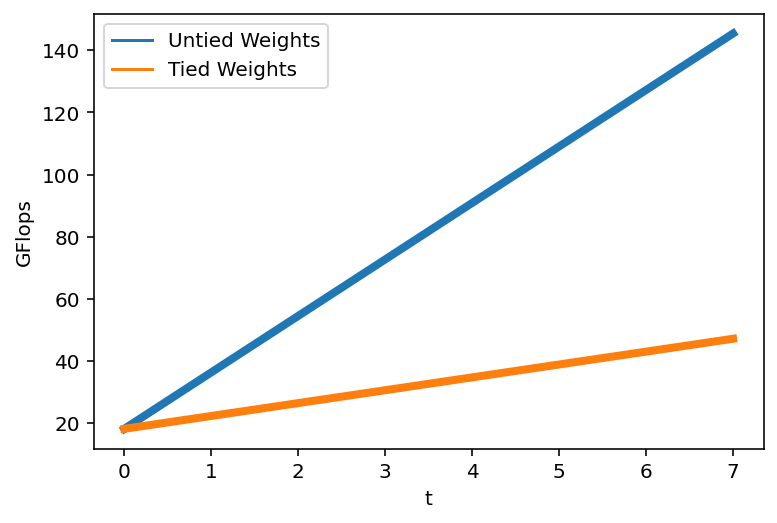

In [14]:
g = sns.lineplot(
  x="t", 
  y="GFlops", 
  hue="exp_name", 
  data=flops_df,
  lw=4,
)
plt.legend(title="")

## Load Results

In [331]:
root = f"/hdd3/mliuzzolino/TDPoseEstimation/results/mpii"

In [27]:
X_batches = []
targets = []
for i, (x_data, target, target_weight, meta) in enumerate(valid_loader):
  sys.stdout.write(f"\rGenerating batch {i+1:,}/{len(valid_loader):,}")
  sys.stdout.flush()
  X_batches.append(x_data)
  targets.append(target)

Generating batch 93/93

In [332]:
exp_paths = np.sort(glob.glob(f"{root}/*"))
len(exp_paths)

15

In [333]:
[print(os.path.basename(e)) for e in exp_paths];

hourglass_x8__TD_0.0
hourglass_x8__TD_0.0__distill__TD_1.0
hourglass_x8__TD_0.0__distill__TD_1.0__untied_weights
hourglass_x8__TD_0.25
hourglass_x8__TD_0.25__distill__TD_1.0
hourglass_x8__TD_0.25__distill__TD_1.0__untied_weights
hourglass_x8__TD_0.5
hourglass_x8__TD_0.5__distill__TD_1.0
hourglass_x8__TD_0.5__distill__TD_1.0__untied_weights
hourglass_x8__TD_0.9
hourglass_x8__TD_0.9__distill__TD_1.0
hourglass_x8__TD_0.9__distill__TD_1.0__untied_weights
hourglass_x8__TD_1.0
hourglass_x8__TD_1.0__distill__TD_1.0
hourglass_x8__TD_1.0__distill__TD_1.0__untied_weights


In [334]:
target_exps = [
  "hourglass_x8__TD_0.25__distill__TD_1.0",
  "hourglass_x8__TD_0.25__distill__TD_1.0__untied_weights",
]

In [335]:
exp_paths = [ele for ele in exp_paths if os.path.basename(ele) in target_exps]
exp_paths

['/hdd3/mliuzzolino/TDPoseEstimation/results/mpii/hourglass_x8__TD_0.25__distill__TD_1.0',
 '/hdd3/mliuzzolino/TDPoseEstimation/results/mpii/hourglass_x8__TD_0.25__distill__TD_1.0__untied_weights']

In [371]:
thresholds

array([0.1       , 0.15714286, 0.21428571, 0.27142857, 0.32857143,
       0.38571429, 0.44285714, 0.5       , 0.55714286, 0.61428571,
       0.67142857, 0.72857143, 0.78571429, 0.84285714, 0.9       ])

In [374]:
JOINT_LEVEL = True
thresholds = np.linspace(0.1, 0.9, 15)
df_dict = defaultdict(list)
for i, exp_path in enumerate(exp_paths):
  print(f"Experiment {i+1}/{len(exp_paths)}...")
  exp_name_src = os.path.basename(exp_path)
  distillation, tied_weights, teacher_td, student_td, exp_name = parse_basename(exp_name_src)
  batch_data_paths = np.sort(glob.glob(f"{exp_path}/*.pt"))
  sample_i = 0
  for batch_i, batch_data_path in enumerate(batch_data_paths):
    if batch_i > 0:
      break
    batch_outputs = torch.load(batch_data_path)["outputs"].cpu().detach()
    batch_targets = targets[batch_i]
    
    for time_i, batch_output in enumerate(batch_outputs):
      stdout_str = f"\rLoading batch data {batch_i+1}/{len(batch_data_paths)}, "
      stdout_str += f"t={time_i+1}/{len(batch_outputs)}..."
      sys.stdout.write(stdout_str)
      sys.stdout.flush()
      for output, target in zip(batch_output, batch_targets):
        output = output.unsqueeze(dim=0)
        target = target.unsqueeze(dim=0)
        for threshold in thresholds:
          correct_joints, avg_acc, cnt, pred = accuracy(
              output.numpy(),
              target.numpy(),
              threshold=threshold,
          )
          correct_joints = correct_joints[1:]
          if JOINT_LEVEL:
            assert len(thresh_acc) == len(correct_joints)
            for joint_i, correct_joint in enumerate(correct_joints):
              if correct_joint < 0:
                correct_joint = 0
              df_dict["exp_name"].append(exp_name_src)
              df_dict["sample_i"].append(sample_i)
              df_dict["timestep"].append(time_i)
              df_dict["threshold"].append(threshold)
              df_dict["joint_i"].append(joint_i)
              df_dict["correct"].append(correct_joint)
          else:
            df_dict["exp_name"].append(exp_name_src)
            df_dict["sample_i"].append(sample_i)
            df_dict["timestep"].append(time_i)
            df_dict["GFlops"].append(time_to_flops_lookup[time_i])
            df_dict["threshold"].append(threshold)
            df_dict["acc"].append(avg_acc)
        sample_i += 1
  print("\n")
full_df = pd.DataFrame(df_dict)

Experiment 1/2...
Loading batch data 1/93, t=8/8...

Experiment 2/2...
Loading batch data 1/93, t=8/8...



In [398]:
joint_0_df = full_df[full_df.joint_i == 0]

In [399]:
df_dict = defaultdict(list)
for exp_name, exp_df in full_df.groupby("exp_name"):
  for joint_i, joint_df in exp_df.groupby("joint_i"):
    for threshold, thresh_df in joint_df.groupby("threshold"):
      avg_acc = thresh_df.correct.mean()
      avg_timestep = thresh_df[thresh_df.correct==1].timestep.mean()
      df_dict["acc"].append(avg_acc)
      df_dict["t"].append(avg_timestep)
      df_dict["exp_name"].append(exp_name)
      df_dict["threshold"].append(threshold)
      df_dict["joint_i"].append(joint_i)
agg_df = pd.DataFrame(df_dict)

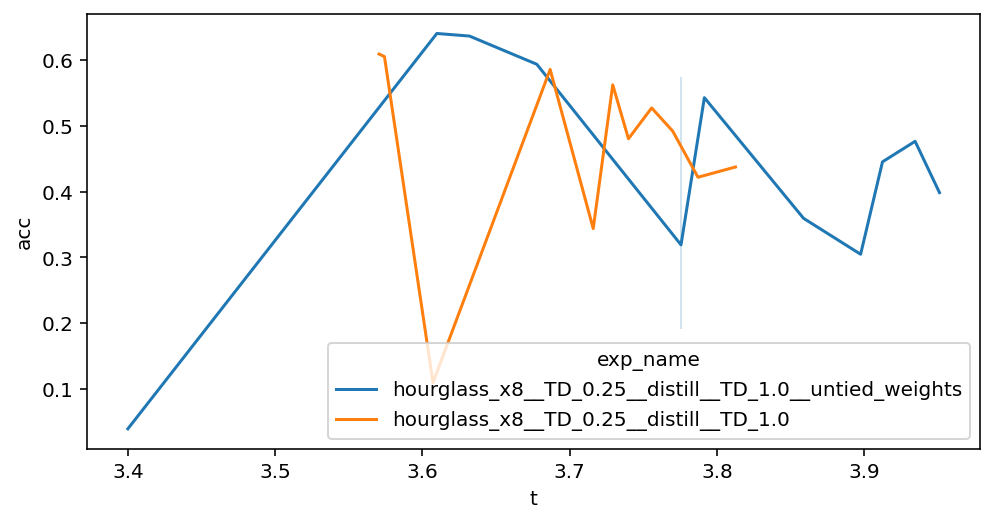

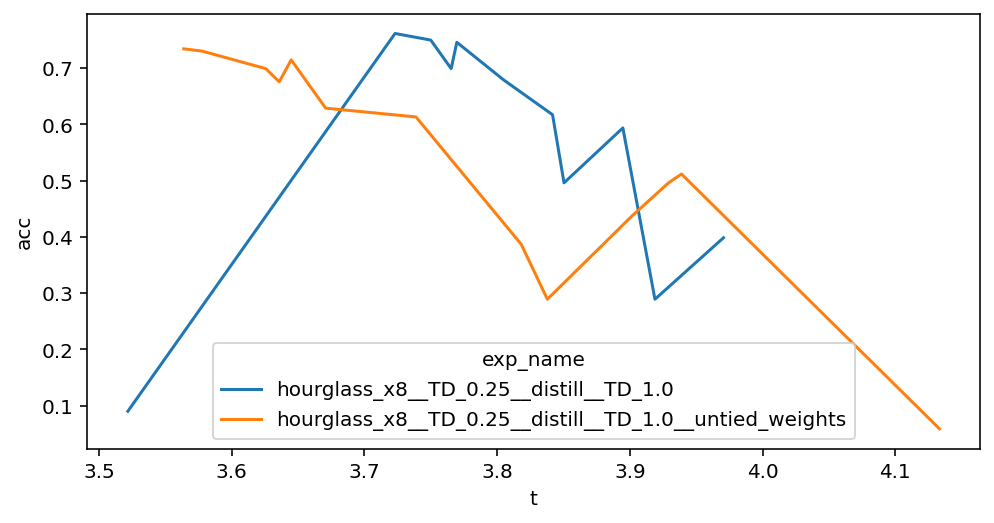

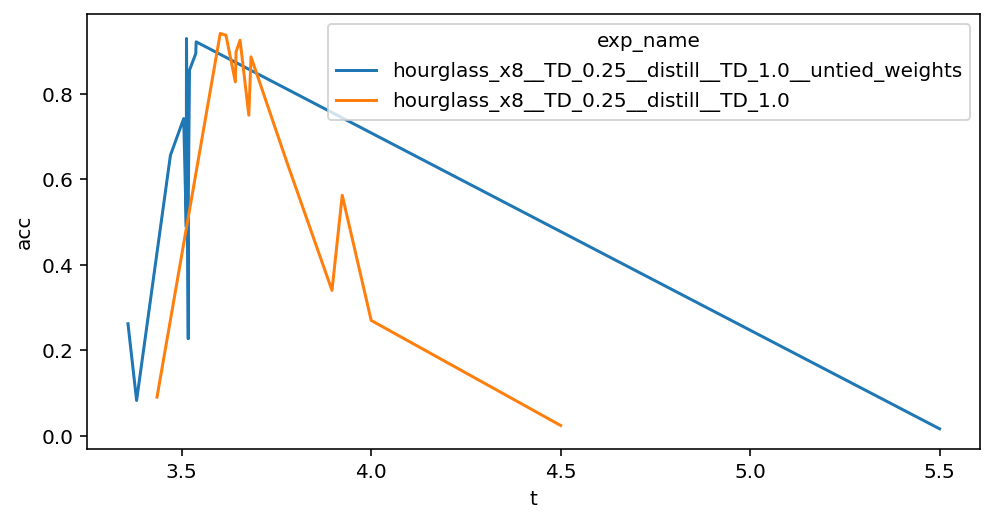

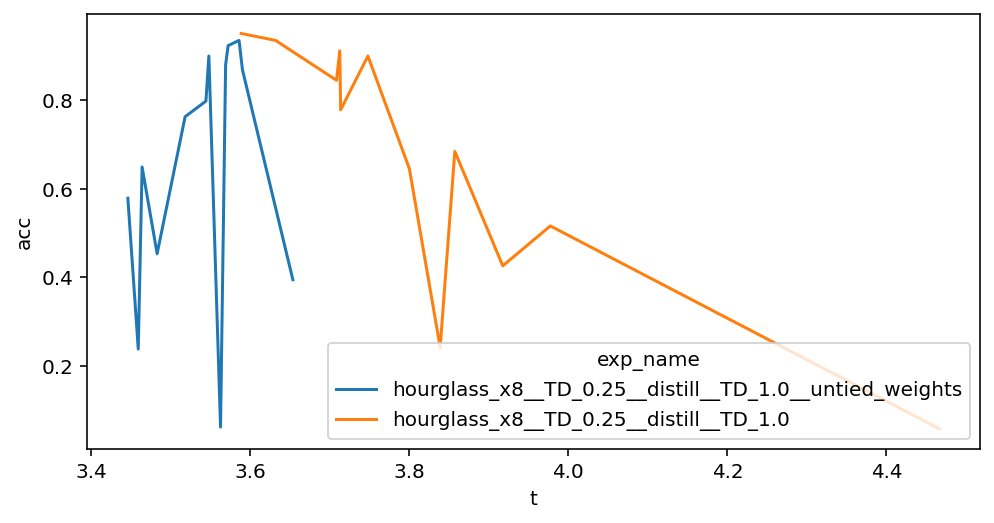

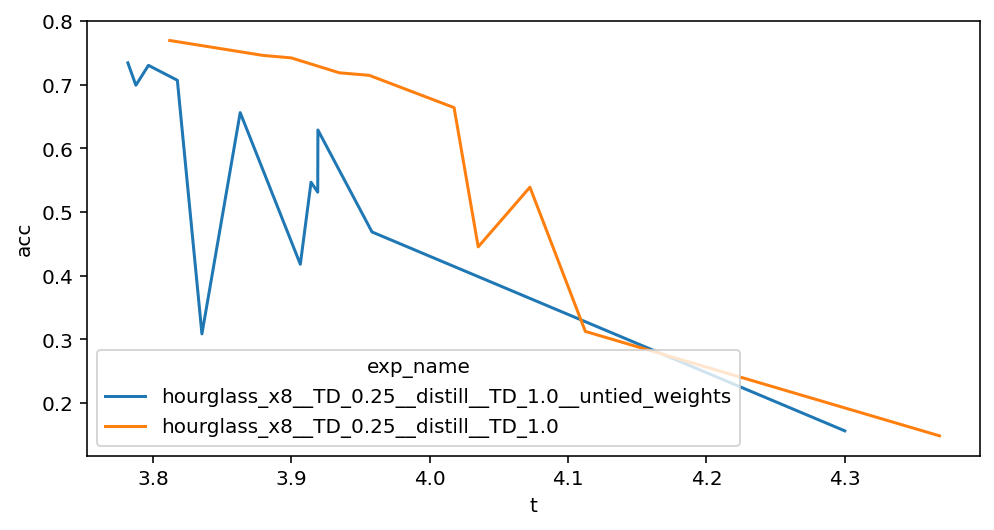

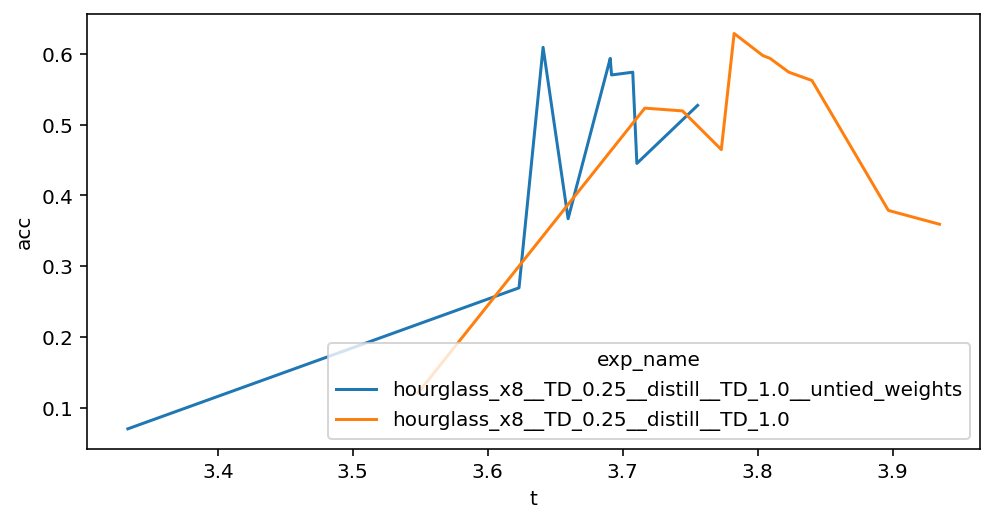

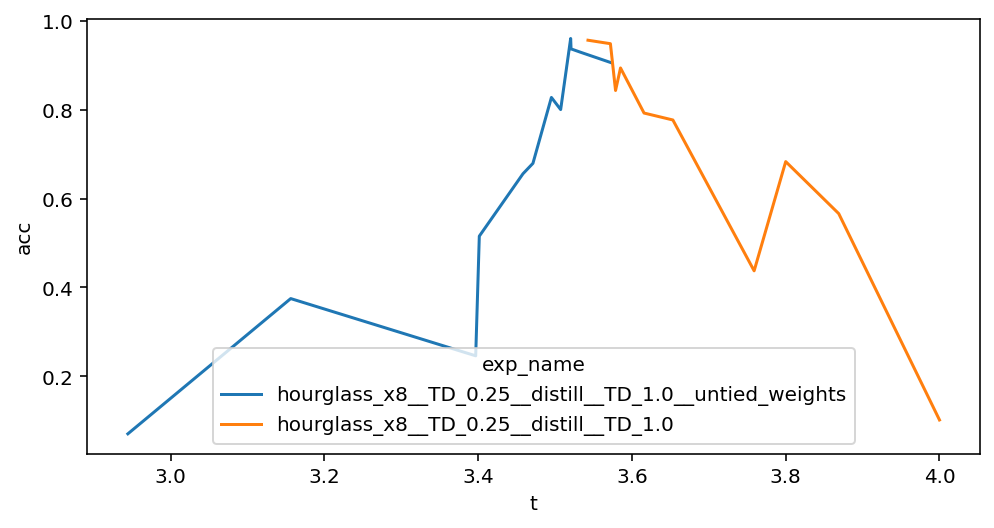

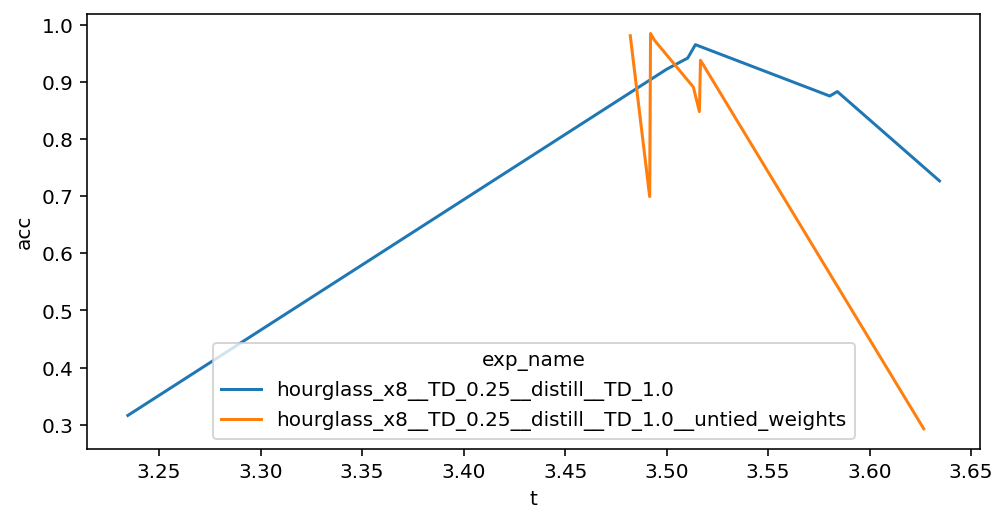

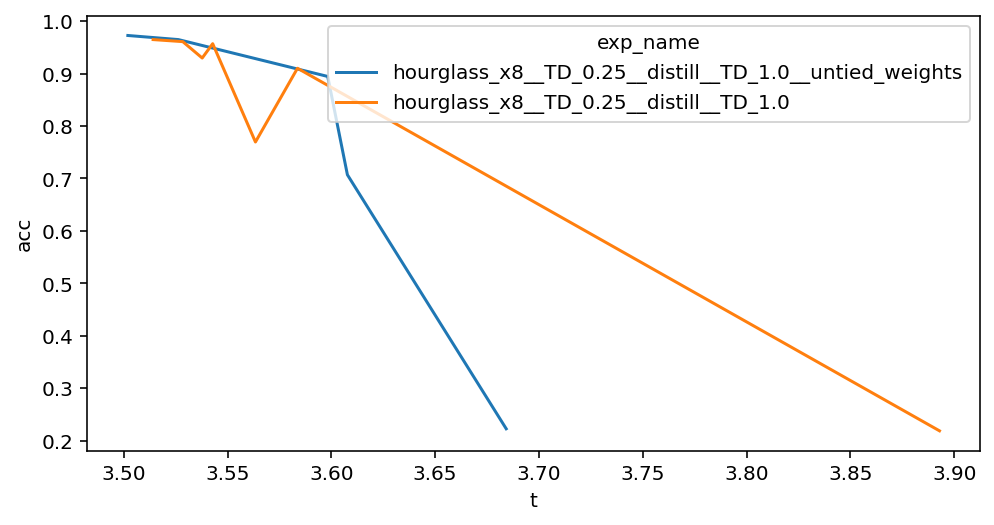

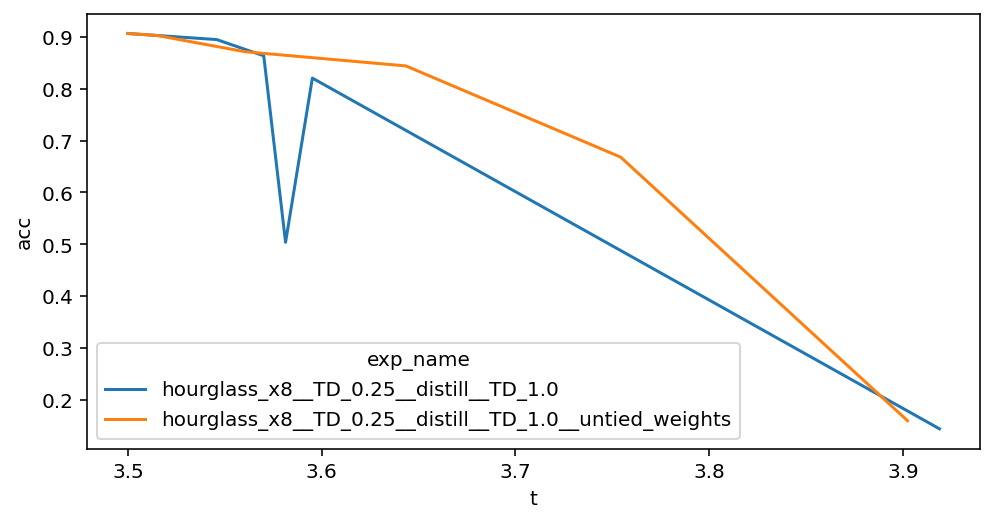

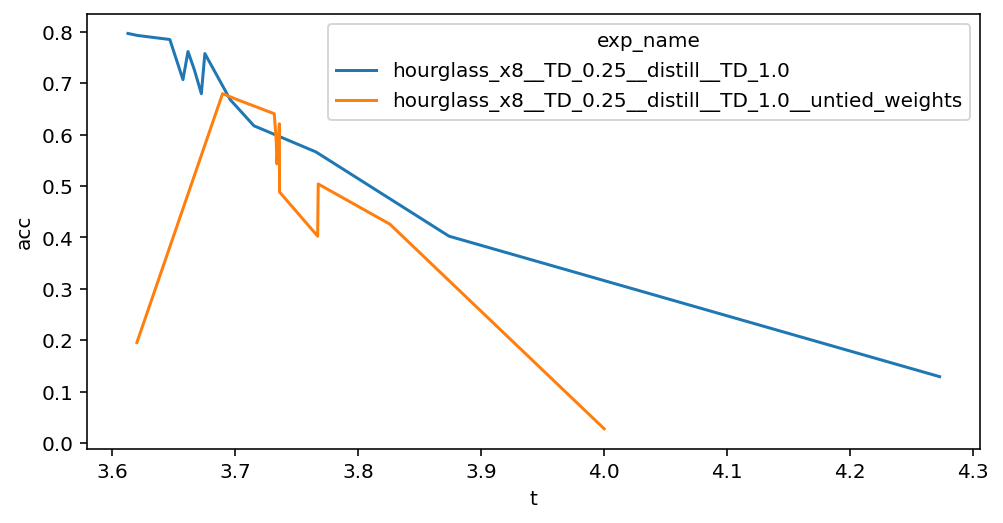

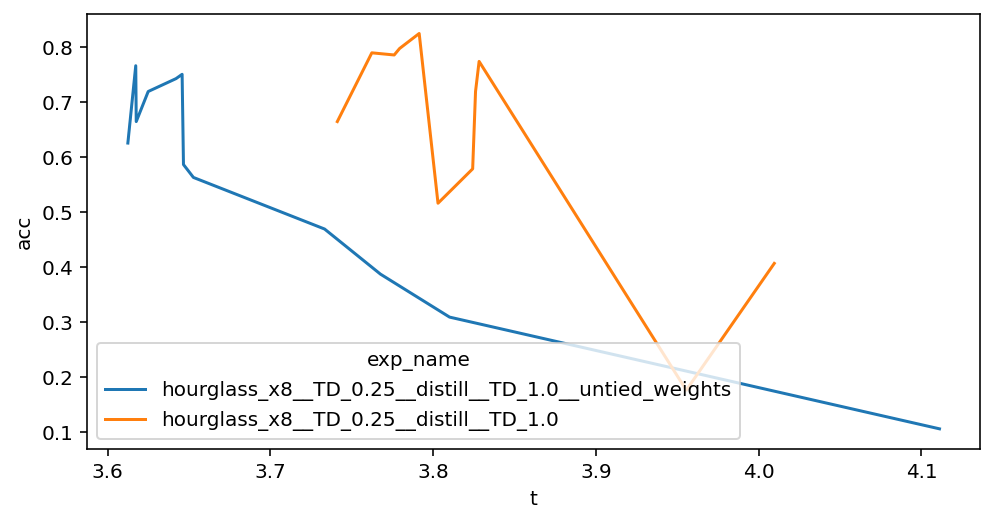

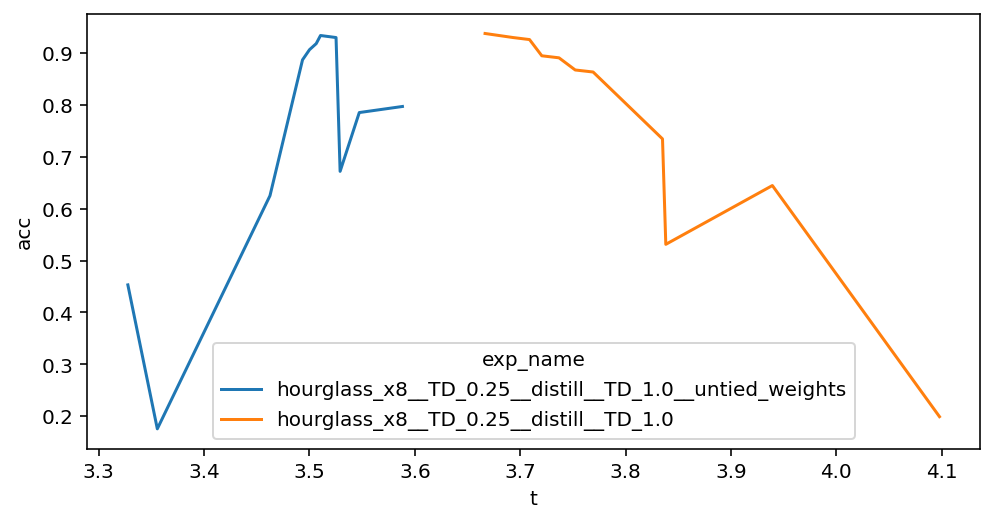

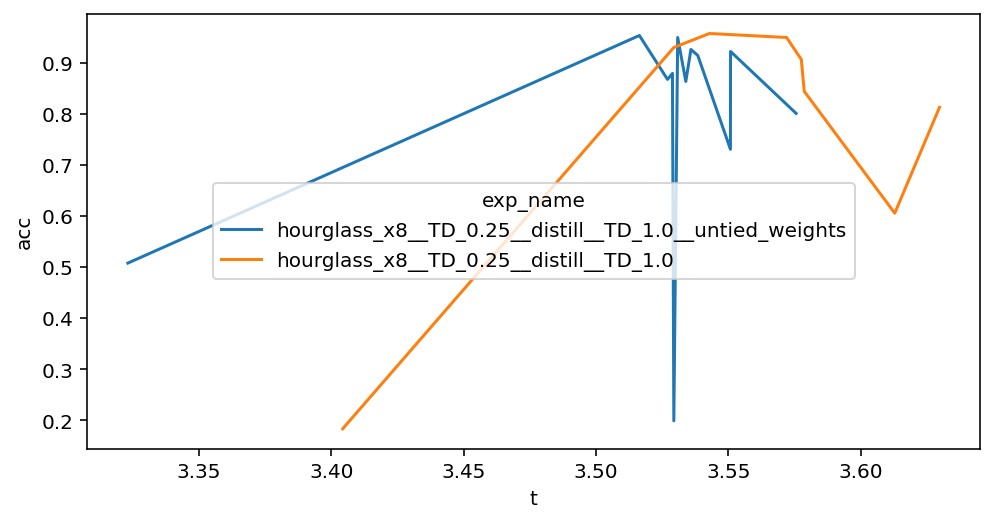

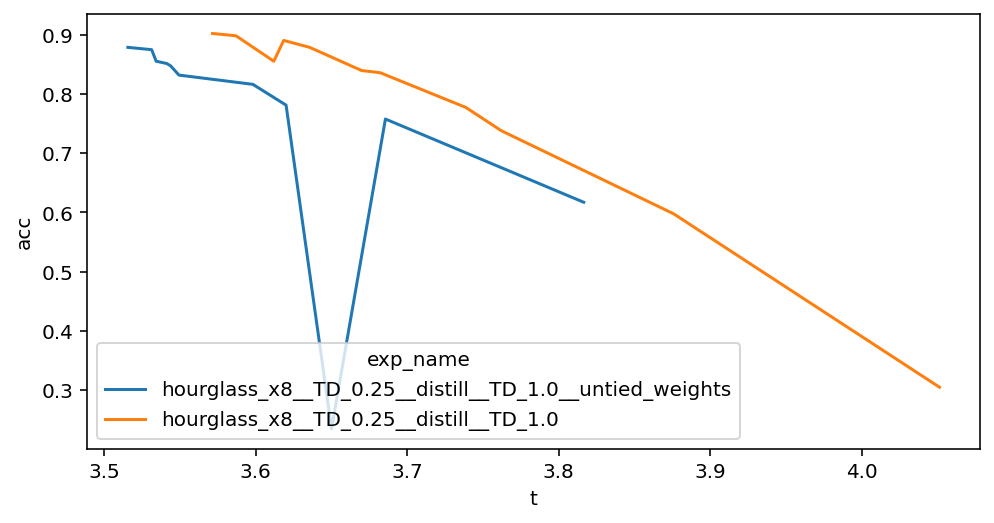

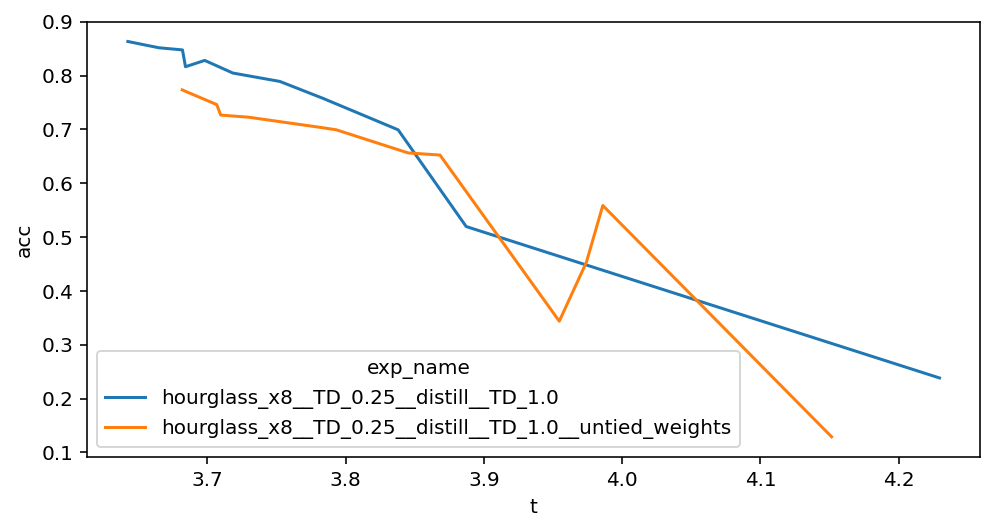

In [400]:
for joint_i, df_i in agg_df.groupby("joint_i"):
  df_i.sort_values("t", inplace=True)
  plt.figure(figsize=(8,4))
  sns.lineplot(x="t", y="acc", hue="exp_name", data=df_i)

In [401]:
thresh_df.correct.mean()

0.7734375

In [270]:
df_dict = defaultdict(list)
exp_g = new_dfs.groupby("exp_name")
for exp_i, (exp_name, exp_df) in enumerate(exp_g):
  thresh_g = exp_df.groupby("new_threshold")
  for thresh_i, (threshold, df_i) in enumerate(thresh_g):
    sys.stdout.write(f"\rProcessing {exp_i+1}/{len(exp_g)}, Threshold {thresh_i+1}/{len(thresh_g)}...")
    sys.stdout.flush()
    avg_df_i = df_i.mean()
    avg_acc = np.mean(avg_df_i.correct)
    avg_timestep = df_i[df_i.correct==1].timestep.mean()
    avg_gflops = df_i[df_i.correct==1].GFlops.mean()
    df_dict["exp_name"].append(exp_name)
    df_dict["threshold"].append(threshold)
    df_dict["timesteps"].append(avg_timestep)
    df_dict["GFlops"].append(avg_gflops)
    df_dict["acc"].append(avg_acc)
agg_df = pd.DataFrame(df_dict)

Processing 2/2, Threshold 21/21...

In [271]:
agg_df["acc_2"] = [1 - ele for ele in agg_df.acc]

In [273]:
agg_df.sort_values("GFlops", inplace=True)

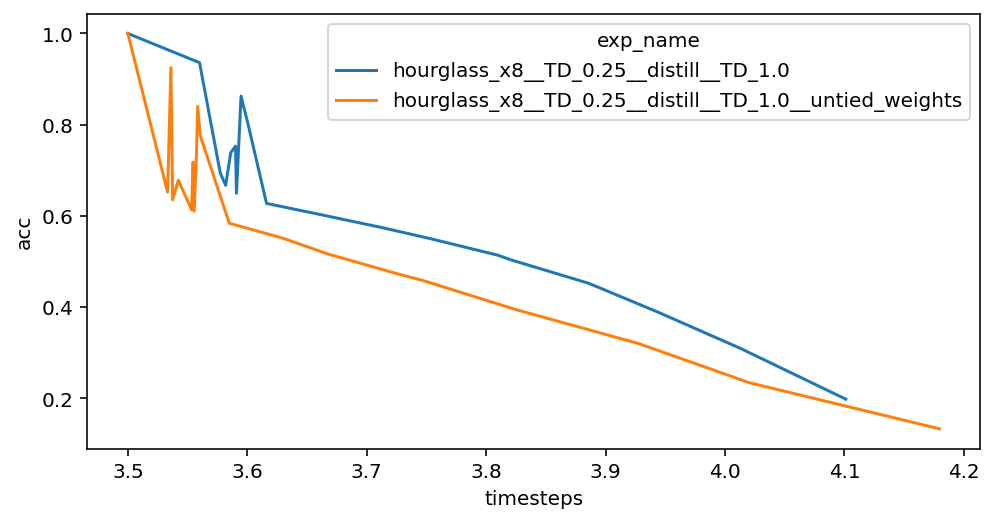

In [276]:
plt.figure(figsize=(8,4))
g = sns.lineplot(x="timesteps", y="acc", hue="exp_name", data=agg_df)

In [218]:
avg_acc

0.15063875347851005

In [174]:
# avg_df = full_df.groupby(["timestep", "threshold"], as_index=False).mean()
# avg_df.drop(columns=["sample_i"])

In [191]:
palettes = [plt.cm.cool, plt.cm.magma]

hourglass_x8__TD_0.25__distill__TD_1.0
hourglass_x8__TD_0.25__distill__TD_1.0__untied_weights


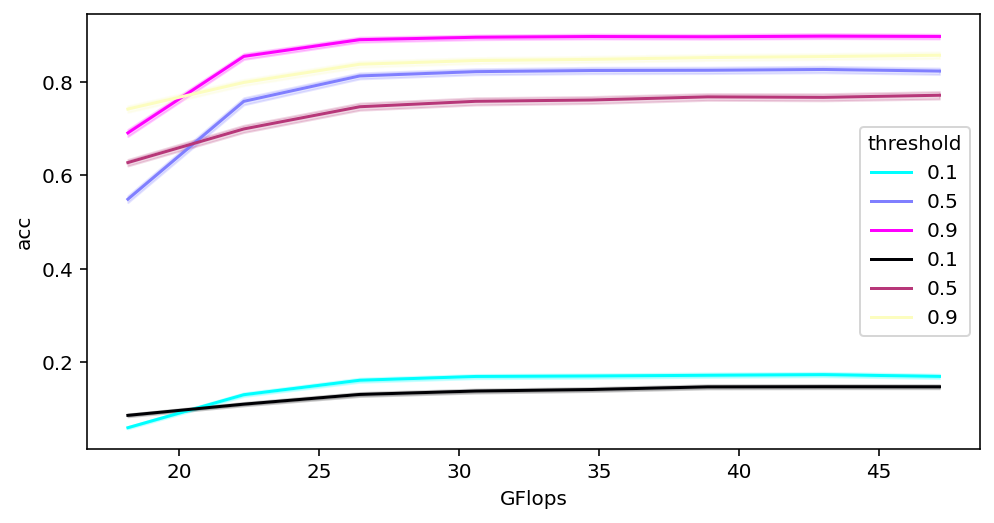

In [209]:
plt.figure(figsize=(8,4))
for i, (exp_key, df_i) in enumerate(full_df.groupby("exp_name")):
  print(exp_key)
  sns.lineplot(
    x="GFlops",
    y="acc",
    hue="threshold",
    data=df_i,
    palette=palettes[i]
  )